# How to get upvotes for a kernel on Kaggle?

In [2]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from plotly import tools

# plotly and cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

In [65]:
#import machine learning

from sklearn.linear_model import LinearRegression

## Introduction

I have recently joined Kaggle and started to create public kernels. My kernels have a lot of views, but no upvotes. So I decided to analyze Meta Kaggle dataset to find out:
* Statistics for kernels, which were awarded medals and have a lot of upvotes.
* Characteristics of awarded kernels.
* And finally, reveal the recommendations on how to make the kernel useful, so other kagglers would cast upvotes.

## Import datasets related to kernels

In [113]:
#import datasets

kernels = pd.read_csv('meta-kaggle/Kernels.csv')
kernel_lang = pd.read_csv('meta-kaggle/KernelLanguages.csv')
kernel_tags = pd.read_csv('meta-kaggle/KernelTags.csv')
kernel_votes = pd.read_csv('meta-kaggle/KernelVotes.csv')
kernel_versions = pd.read_csv('meta-kaggle/KernelVersions.csv')
kernel_competitions = pd.read_csv('meta-kaggle/KernelVersionCompetitionSources.csv')
kernel_users = pd.read_csv('meta-kaggle/Users.csv')
datasets = pd.read_csv('meta-kaggle/Datasets.csv')
kernel_datasets = pd.read_csv('meta-kaggle/KernelVersionDatasetSources.csv')
dataset_versions = pd.read_csv('meta-kaggle/DatasetVersions.csv')

tags = pd.read_csv('meta-kaggle/Tags.csv')
competitions = pd.read_csv('meta-kaggle/Competitions.csv')

In [5]:
kernels.head()

,Id,AuthorUserId,CurrentKernelVersionId,ForkParentKernelVersionId,ForumTopicId,FirstKernelVersionId,CreationDate,EvaluationDate,MadePublicDate,IsProjectLanguageTemplate,CurrentUrlSlug,Medal,MedalAwardDate,TotalViews,TotalComments,TotalVotes
0,1,2505,205.0,NaN,NaN,1.0,3/25/2015 6:25:32 PM,3/23/2018,3/25/2015,False,hello,NaN,NaN,25,0,0
1,2,3716,1748.0,NaN,26670.0,2.0,3/25/2015 6:31:07 PM,4/16/2015,3/25/2015,False,rf-proximity,3.0,7/15/2016,7604,1,12
2,4,3716,41.0,NaN,NaN,9.0,3/25/2015 9:57:36 PM,3/23/2018,3/25/2015,False,r-version,NaN,NaN,9,0,0
3,5,28963,19.0,NaN,NaN,13.0,3/25/2015 10:01:04 PM,3/23/2018,3/25/2015,False,test1,NaN,NaN,9,0,0
4,6,3716,21.0,NaN,NaN,15.0,3/25/2015 10:19:00 PM,3/23/2018,3/25/2015,False,are-icons-missing,NaN,NaN,7,0,0


In [7]:
kernel_lang.head()

,Id,Name,DisplayName,IsNotebook
0,1,R,R,False
1,2,Python,Python,False
2,5,RMarkdown,R,False
3,8,IPython Notebook,Python,True
4,9,IPython Notebook HTML,Python,False


In [8]:
kernel_tags.head()

,Id,KernelId,TagId
0,33359,1740620,4141
1,33358,1740620,3004
2,33362,1740620,13202
3,33360,1740620,7408
4,33357,1740620,2605


In [9]:
kernel_votes.head()

,Id,UserId,KernelVersionId,VoteDate
0,456760,2234887,5301226,11/8/2018
1,457004,556640,5301226,11/8/2018
2,457286,1987798,5301226,11/8/2018
3,476618,2409821,5301226,11/22/2018
4,476776,1329015,5301226,11/22/2018


In [10]:
kernel_versions.head()

,Id,KernelId,ParentKernelVersionId,KernelLanguageId,AuthorUserId,CreationDate,VersionNumber,Title,EvaluationDate,IsChange,TotalLines,LinesInsertedFromPrevious,LinesChangedFromPrevious,LinesUnchangedFromPrevious,LinesInsertedFromFork,LinesDeletedFromFork,LinesChangedFromFork,LinesUnchangedFromFork,TotalVotes
0,1,1,NaN,1,2505,3/25/2015 6:25:32 PM,1.0,hello,3/23/2018,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,2,NaN,1,3716,3/25/2015 6:31:07 PM,1.0,RF Proximity,3/23/2018,True,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,8,2,NaN,1,3716,3/25/2015 6:51:15 PM,2.0,RF Proximity,3/23/2018,True,79.0,0.0,0.0,80.0,NaN,NaN,NaN,NaN,0
3,9,4,NaN,1,3716,3/25/2015 9:57:36 PM,1.0,R version,3/23/2018,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,10,4,NaN,1,3716,3/25/2015 9:57:44 PM,2.0,R version,3/23/2018,True,1.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,0


In [16]:
kernel_competitions.head()

,Id,KernelVersionId,SourceCompetitionId
0,999822,116734,4594
1,971354,116747,4594
2,999825,116842,4594
3,996732,116696,4594
4,998089,116725,4594


In [18]:
tags.head()

,Id,ParentTagId,Name,Slug,FullPath,Description,DatasetCount,CompetitionCount,KernelCount
0,1000,NaN,general reference,general-reference,general reference,NaN,0,0,0
1,1100,1000.0,reference works,reference-works,general reference > reference works,NaN,0,0,0
2,1103,1100.0,biography,biography,general reference > reference works > biography,Who did what and when? This tag contains infor...,3,0,0
3,1104,1100.0,dictionaries,dictionaries,general reference > reference works > dictiona...,"A dictionary, sometimes known as a wordbook, i...",6,0,2
4,1106,1100.0,encyclopedias,encyclopedias,general reference > reference works > encyclop...,An encyclopedia is a reference work or compend...,1,0,0


In [19]:
competitions.head()

,Id,Slug,Title,Subtitle,HostSegmentTitle,ForumId,OrganizationId,CompetitionTypeId,HostName,EnabledDate,...,EnableSubmissionModelHashes,EnableSubmissionModelAttachments,RewardType,RewardQuantity,NumPrizes,UserRankMultiplier,CanQualifyTiers,TotalTeams,TotalCompetitors,TotalSubmissions
0,2408,Eurovision2010,Forecast Eurovision Voting,This competition requires contestants to forec...,Featured,2.0,NaN,1,NaN,4/7/2010 7:57:43 AM,...,False,False,USD,1000.0,1,1.0,False,22,25,22
1,8910,blg-454e-term-project-competition,BLG 454E Term Project Competition,"ITU Computer and Informatics Faculty, BLG 454E...",InClass,24780.0,NaN,1,NaN,3/17/2018 7:08:56 PM,...,False,False,NaN,0.0,0,0.0,False,29,65,658
2,8916,test-xx,test-xx,this is a test,InClass,24867.0,NaN,1,NaN,3/18/2018 11:52:38 AM,...,False,False,NaN,0.0,0,0.0,False,0,0,7
3,8933,recsys-20181-cfmr,RecSys 2018/1: Collaborative Movie Recommendation,Predict users' ratings for movies,InClass,25077.0,NaN,1,NaN,3/19/2018 3:34:50 PM,...,False,False,NaN,0.0,0,0.0,False,27,28,737
4,8866,bonus-410-spring-2018,Bonus 410 Spring 2018,A competition to help you start using the trai...,InClass,24237.0,NaN,1,NaN,3/14/2018 6:08:58 PM,...,False,False,NaN,0.0,0,0.0,False,11,11,66


In [90]:
kernel_users.head(3)

,Id,UserName,DisplayName,RegisterDate,PerformanceTier
0,1,kaggleteam,Kaggle Team,3/24/2011,5
1,368,antgoldbloom,Anthony Goldbloom,1/20/2010,5
2,381,iguyon,Isabelle,1/29/2010,2


In [109]:
datasets.head(3)

,Id,CreatorUserId,OwnerUserId,OwnerOrganizationId,CurrentDatasetVersionId,CurrentDatasourceVersionId,ForumId,Type,CreationDate,ReviewDate,FeatureDate,LastActivityDate,TotalViews,TotalDownloads,TotalVotes,TotalKernels
0,52146,1,NaN,223.0,281965.0,294410.0,60824,2,9/12/2018 9:13:38 PM,NaN,NaN,9/12/2018,179,3,0,1
1,52222,1135944,1135944.0,NaN,97664.0,100200.0,60904,2,9/13/2018 5:06:57 AM,NaN,NaN,9/13/2018,151,4,1,2
2,53090,2251685,2251685.0,NaN,100925.0,103465.0,61797,2,9/16/2018 7:26:26 AM,NaN,NaN,9/16/2018,91,0,0,1


In [112]:
kernel_datasets.head(3)

,Id,KernelVersionId,SourceDatasetVersionId
0,211918,328609,331
1,240420,330097,102
2,395230,330481,2157


In [114]:
dataset_versions.head(3)

,Id,DatasetId,DatasourceVersionId,CreatorUserId,LicenseName,CreationDate,VersionNumber,Title,Slug,Subtitle,Description,VersionNotes,TotalCompressedBytes,TotalUncompressedBytes
0,6198,3955,6198,1389049,CC0: Public Domain,11/4/2017 11:37:49 AM,1.0,DateasetTEst,dateasettest,NaN,NaN,Initial release,0.0,0.0
1,6249,3996,6249,1287548,Other (specified in description),11/5/2017 1:44:04 AM,1.0,Toyota Corolla (clean),toyota-corolla-clean,Finding ways to predict or classify car prices,### Content\nThis dataset is quite simple. Bel...,Initial release,0.0,0.0
2,13418,9467,13418,1396170,CC0: Public Domain,1/12/2018 11:41:46 AM,1.0,A-Z Handwritten Alphabets,a-z handwritten alphabets,English Alphabets Data-set,### Context\n\nFor recognising handwritten for...,Initial release,0.0,0.0


## Explore statistics for awarded and upvoted kernels

### 1. Explore basic statistics for number of kernels

* How many kernels are there? 
* How many of them are public? 
* How many kernels have upvotes? 
* How many kernels have any medal?

In [21]:
total_kernels = len(kernels['Id'].unique())

print('Total number of kernels: {total_kernels}'.format(total_kernels = total_kernels))

Total number of kernels: 221289


In [29]:
total_public = len(kernels[pd.notnull(kernels['MadePublicDate'])])

print('Total number of public kernels: {total_public_kernels}'.format(total_public_kernels = total_public))

Total number of public kernels: 210730


In [23]:
total_upvoted = len(kernels[ kernels['TotalVotes'] > 0])

print('Total number of kernels with upvotes: {total_upvoted}'.format(total_upvoted = total_upvoted))

Total number of kernels with upvotes: 45096


In [25]:
total_awarded = len(kernels[np.isfinite(kernels['Medal'])])

print('Total number of kernels with any medal: {total_awarded}'.format(total_awarded = total_awarded))

Total number of kernels with any medal: 8823


In [30]:
total_no_upvotes = total_public - total_upvoted

print('Total number of public kernels with no upvotes: {total_no_upvotes}'.format(total_no_upvotes = total_no_upvotes))

Total number of public kernels with no upvotes: 165634


In [31]:
total_private = total_kernels - total_public

print('Total number of private kernels: {total_private}'.format(total_private = total_private))

Total number of private kernels: 10559


Plot statistics for number of kernels:

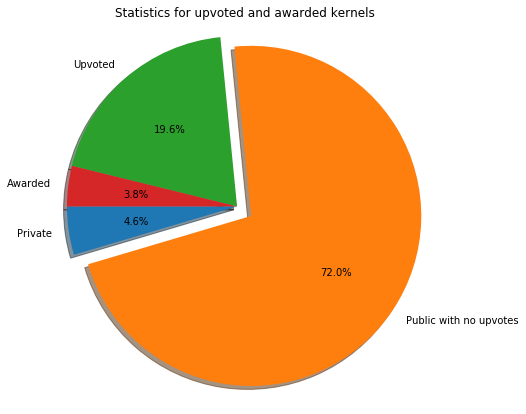

In [47]:
#plot statistics with matplotlib

labels = 'Private', 'Public with no upvotes', 'Upvoted', 'Awarded'
sizes = [total_private, total_no_upvotes, total_upvoted, total_awarded]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.set_figheight(7)
fig1.set_figwidth(7)

plt.title('Statistics for upvoted and awarded kernels')

plt.show()

In [51]:
#plot statistics with plotly

labels = ['Private', 'Public with no upvotes', 'Upvoted', 'Awarded']
values = [total_private, total_no_upvotes, total_upvoted, total_awarded]

colors = ['#7FDBE2', '#68B6AF', '#82C5A0', '#EED2BB']

trace = go.Pie(labels=labels, values=values, marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2)))

data = [trace]
layout = go.Layout(title='Statistics for upvoted and awarded kernels')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='upvoted_pie_chart')

### 2. How does number of views and number of comments affect number of votes?

* Is there a correlation between number of views and number of comments with number of votes?
* Plot dependencies between number of views, comments and number of votes.

Find out correlation between number of views, number of comments and number of votes:

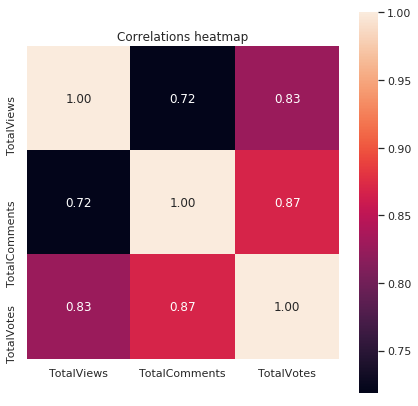

In [52]:
#columns to find out correlation
cols = ['TotalViews', 'TotalComments', 'TotalVotes']

#Find out correlation between columns and plot
corrs = np.corrcoef(kernels[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()
fig.savefig('correlations.png')

We can see that votes, comments and views are __highly correlated__. So my first assumption would be that __we should get as many views of the kernels as possible to gain votes__.

Let's try to visualize dependency between views and votes:

In [68]:
#get average number of votes per number of views
votes_by_views = kernels.groupby('TotalViews').mean().reset_index()[['TotalViews', 'TotalVotes']]
votes_by_views = votes_by_views.sort_values(by = 'TotalViews', ascending = True)

# fit a linear regression model on views and votes data
model = LinearRegression()
model.fit(votes_by_views['TotalViews'].values.reshape(-1, 1), votes_by_views['TotalVotes'].values.reshape(-1, 1))

inputs = np.linspace(1, 1200000, num=50)
predictions = model.predict(inputs.reshape(-1,1))

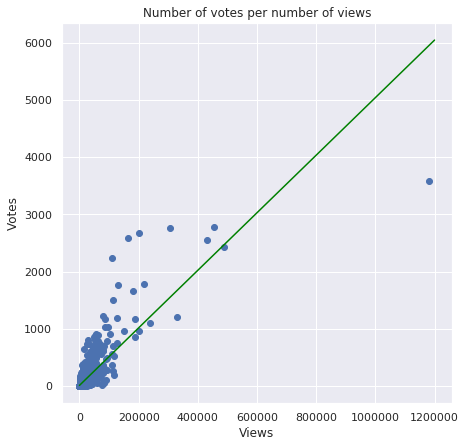

In [70]:
#plot with matplotlib along with predictions from the linear regression model

plt.scatter(votes_by_views['TotalViews'], votes_by_views['TotalVotes'])
plt.plot(inputs, predictions, color='green')

plt.title("Number of votes per number of views")
plt.xlabel("Views")
plt.ylabel("Votes")

plt.show()

In [76]:
#plot with plotly

# Create traces
trace0 = go.Scatter(
    x = votes_by_views['TotalViews'], 
    y = votes_by_views['TotalVotes'],
    mode = 'markers',
    name = 'votes per views scatter',
    marker = dict(color = '#7FDBE2')
    #color = '#7FDBE2'
)

trace1 = go.Scatter(
    x = inputs,
    y = predictions,
    mode = 'lines',
    name = 'votes per views trendline',
    line=dict(width=4, color='#EED2BB')
)

data = [trace0, trace1]

layout = go.Layout(
    title='Number of votes per number of views',
    xaxis=dict(title='Views', ticklen=5, zeroline=False, gridwidth=2),
    yaxis=dict(title='Votes', ticklen=5, gridwidth=2),
    showlegend=True
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='votes_per_views')

Visualization of dependency between comments and votes:

In [86]:
#get average number of votes per number of comments
votes_by_comments = kernels.groupby('TotalComments').mean().reset_index()[['TotalComments', 'TotalVotes']]
votes_by_comments = votes_by_comments.sort_values(by = 'TotalComments', ascending = True)

# fit a linear regression model on comments and votes data
model = LinearRegression()
model.fit(votes_by_comments['TotalComments'].values.reshape(-1, 1), votes_by_comments['TotalVotes'].values.reshape(-1, 1))

inputs = np.linspace(1, 1000, num=50)
predictions = model.predict(inputs.reshape(-1,1))

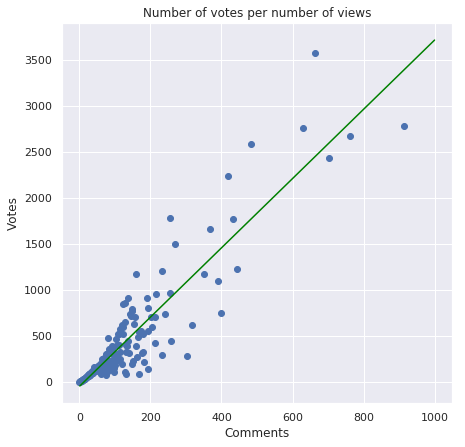

In [87]:
#plot with matplotlib along with predictions from the linear regression model

plt.scatter(votes_by_comments['TotalComments'], votes_by_comments['TotalVotes'])
plt.plot(inputs, predictions, color='green')

plt.title("Number of votes per number of views")
plt.xlabel("Comments")
plt.ylabel("Votes")

plt.show()

In [88]:
#plot with plotly

# Create traces
trace0 = go.Scatter(
    x = votes_by_comments['TotalComments'], 
    y = votes_by_comments['TotalVotes'],
    mode = 'markers',
    name = 'votes per comments scatter',
    marker = dict(color = '#7FDBE2')
)

trace1 = go.Scatter(
    x = inputs,
    y = predictions,
    mode = 'lines',
    name = 'votes per comments trendline',
    line=dict(width=4, color='#EED2BB')
)

data = [trace0, trace1]

layout = go.Layout(
    title='Number of votes per number of comments',
    xaxis=dict(title='Comments', ticklen=5, zeroline=False, gridwidth=2),
    yaxis=dict(title='Votes', ticklen=5, gridwidth=2),
    showlegend=True
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='votes_per_comments')

/Users/aleksandraastakhova/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### 3. How does the status of the author affect number of votes per kernel?

I suppose that more active users and the users with higher visibility gain votes for kernels:
* So how does performance tier of the user affect the number of upvotes?

In [91]:
#merge kernels with users
kernel_users_renamed = kernel_users.rename(columns={'Id': 'AuthorUserId'})
kernels_user_tiers = kernels.merge(kernel_users_renamed, on = 'AuthorUserId')

In [92]:
kernels_user_tiers.head()

,Id,AuthorUserId,CurrentKernelVersionId,ForkParentKernelVersionId,ForumTopicId,FirstKernelVersionId,CreationDate,EvaluationDate,MadePublicDate,IsProjectLanguageTemplate,CurrentUrlSlug,Medal,MedalAwardDate,TotalViews,TotalComments,TotalVotes,UserName,DisplayName,RegisterDate,PerformanceTier
0,1,2505,205.0,NaN,NaN,1.0,3/25/2015 6:25:32 PM,3/23/2018,3/25/2015,False,hello,NaN,NaN,25,0,0,jeffmoser,Jeff Moser,8/21/2010,5
1,86,2505,2307564.0,NaN,NaN,548.0,4/3/2015 5:16:32 PM,2/1/2018,4/3/2015,True,hi-python,3.0,9/16/2017,189,0,5,jeffmoser,Jeff Moser,8/21/2010,5
2,107,2505,740.0,NaN,NaN,632.0,4/6/2015 4:04:55 PM,3/23/2018,4/6/2015,False,yet-another-python-sleep-test,NaN,NaN,4,0,0,jeffmoser,Jeff Moser,8/21/2010,5
3,108,2505,748.0,NaN,NaN,636.0,4/6/2015 4:12:14 PM,3/23/2018,4/6/2015,False,more-python-testing,NaN,NaN,6,0,0,jeffmoser,Jeff Moser,8/21/2010,5
4,4345,2505,8879.0,NaN,NaN,8833.0,5/22/2015 2:36:27 PM,5/22/2015,5/22/2015,False,kaggle-io-test,NaN,NaN,17,0,0,jeffmoser,Jeff Moser,8/21/2010,5


In [99]:
#get average number of votes per number of comments
votes_by_usertier= kernels_user_tiers.groupby('PerformanceTier').mean().reset_index()[['PerformanceTier', 'TotalVotes']]
votes_by_usertier = votes_by_usertier.sort_values(by = 'PerformanceTier', ascending = True)

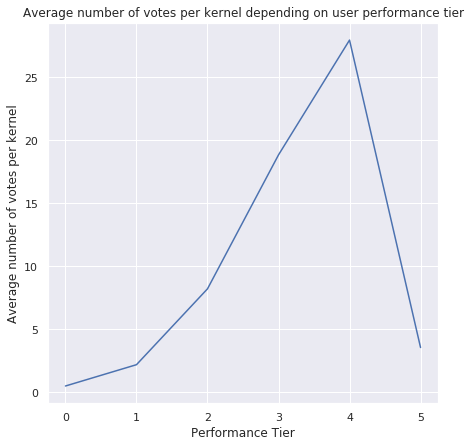

In [102]:
#plot with matplotlib along with predictions from the linear regression model

plt.plot(votes_by_usertier['PerformanceTier'], votes_by_usertier['TotalVotes'])

plt.title("Average number of votes per kernel depending on user performance tier")
plt.xlabel("Performance Tier")
plt.ylabel("Average number of votes per kernel")

plt.show()

In [106]:
#plot with plotly

# Create traces
trace0 = go.Scatter(
    x = votes_by_usertier['PerformanceTier'], 
    y = votes_by_usertier['TotalVotes'],
    mode = 'lines',
    name = 'number of votes per kernel depending on user performance tier',
    line = dict(color = '#7FDBE2')
)

data = [trace0]

layout = go.Layout(
    title='Average number of votes per kernel depending on user performance tier',
    xaxis=dict(title='Performance Tier', ticklen=5, zeroline=False, gridwidth=2),
    yaxis=dict(title='Average number of votes per kernel', ticklen=5, gridwidth=2),
    showlegend=True
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='votes_per_user_tier')

So we can really see that __more proficient users gain more votes for kernels__.

### 4. How does dataset related to kernel affects the number of votes?

I suppose that there might be some 'hot' datasets on Kaggle and kernels related to those datasets might optain more votes. So we should find out:
* How does the number of votes for a dataset affect the number of votes for related kernel?
* How does the number of downloads of a dataset affect the number of votes for related kernel?

In [118]:
#prepare data for the analysis

kernels_truncated = kernels[['Id' , 'CurrentKernelVersionId', 'TotalVotes']]
kernels_truncated = kernels_truncated.rename(columns={'Id': 'KernelId', 'TotalVotes':'TotalKernelVotes',
                                                      'CurrentKernelVersionId':'KernelVersionId'})

kernel_datasets_truncated = kernel_datasets[['KernelVersionId', 'SourceDatasetVersionId']]

dataset_versions_truncated = dataset_versions[['DatasetId', 'DatasourceVersionId']]
dataset_versions_truncated = dataset_versions_truncated.rename(columns={'DatasourceVersionId': 'SourceDatasetVersionId'})

datasets_truncated = datasets[['Id', 'TotalVotes', 'TotalDownloads']]
datasets_truncated = datasets_truncated.rename(columns={'Id': 'DatasetId', 'TotalVotes':'TotalDatasetVotes',
                                                      'TotalDownloads':'TotalDatasetDownloads'})

df_merge = kernels_truncated.merge(kernel_datasets_truncated, on = 'KernelVersionId')
df_merge = df_merge.merge(dataset_versions_truncated, on = 'SourceDatasetVersionId')
df_merge = df_merge.merge(datasets_truncated, on = 'DatasetId')

df_merge.head()

,KernelId,KernelVersionId,TotalKernelVotes,SourceDatasetVersionId,DatasetId,TotalDatasetVotes,TotalDatasetDownloads
0,10707,32514.0,5,2158,6,81,3816
1,10868,33258.0,0,2158,6,81,3816
2,10884,46359.0,21,2158,6,81,3816
3,9969,29938.0,0,2158,6,81,3816
4,10073,29837.0,3,2158,6,81,3816


At first let's look at correlations between TotalKernelVotes, TotalDatasetVotes and	TotalDatasetDownloads.

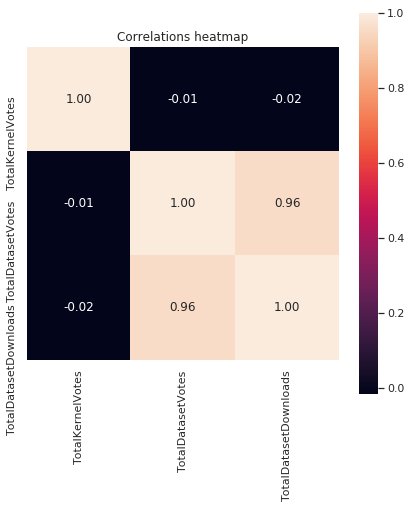

In [128]:
#columns to find out correlation
cols = ['TotalKernelVotes', 'TotalDatasetVotes', 'TotalDatasetDownloads']

#Find out correlation between columns and plot
corrs = np.corrcoef(df_merge[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()
fig.savefig('correlations.png')

As we can see there is no correlation between number of kernel votes and number of votes or downloads for a dataset.
<br> Let's also make scatter plots:

In [121]:
#get average number of votes per number of dataset votes
votes_by_dvotes = df_merge.groupby('TotalDatasetVotes').mean().reset_index()[['TotalDatasetVotes', 'TotalKernelVotes']]
votes_by_dvotes = votes_by_dvotes.sort_values(by = 'TotalDatasetVotes', ascending = True)

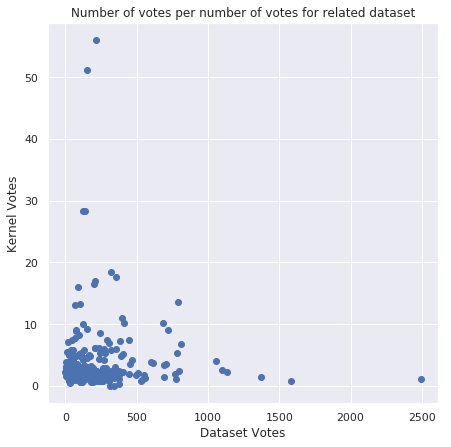

In [122]:
#plot with matplotlib

plt.scatter(votes_by_dvotes['TotalDatasetVotes'], votes_by_dvotes['TotalKernelVotes'])

plt.title("Number of votes per number of votes for related dataset")
plt.xlabel("Dataset Votes")
plt.ylabel("Kernel Votes")

plt.show()

In [124]:
#plot with plotly

# Create traces
trace0 = go.Scatter(
    x = votes_by_dvotes['TotalDatasetVotes'], 
    y = votes_by_dvotes['TotalKernelVotes'],
    mode = 'markers',
    name = 'kernel votes per dataset votes',
    marker = dict(color = '#7FDBE2')
)

data = [trace0]

layout = go.Layout(
    title='Number of votes per number of votes for related dataset',
    xaxis=dict(title='Dataset Votes', ticklen=5, zeroline=False, gridwidth=2),
    yaxis=dict(title='Kernel Votes', ticklen=5, gridwidth=2),
    showlegend=True
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='votes_per_dataset_votes')

Here we can't see a clear dependency of kernel votes on dataset's number of votes. So I suppose that we can create a really helpful and popular kernel for an unpopular dataset and vice versa.

In [125]:
#get average number of votes per number of dataset downloads
votes_by_downloads = df_merge.groupby('TotalDatasetDownloads').mean().reset_index()[['TotalDatasetDownloads', 'TotalKernelVotes']]
votes_by_downloads = votes_by_downloads.sort_values(by = 'TotalDatasetDownloads', ascending = True)

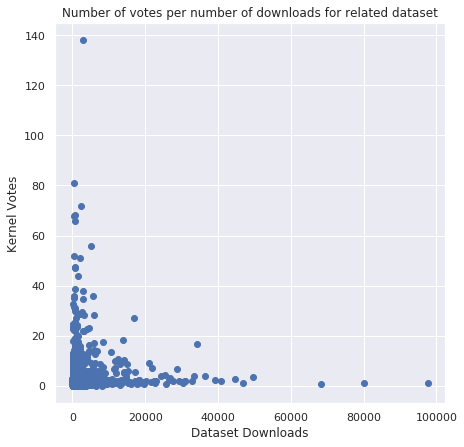

In [126]:
#plot with matplotlib

plt.scatter(votes_by_downloads['TotalDatasetDownloads'], votes_by_downloads['TotalKernelVotes'])

plt.title("Number of votes per number of downloads for related dataset")
plt.xlabel("Dataset Downloads")
plt.ylabel("Kernel Votes")

plt.show()

In [127]:
#plot with plotly

# Create traces
trace0 = go.Scatter(
    x = votes_by_downloads['TotalDatasetDownloads'], 
    y = votes_by_downloads['TotalKernelVotes'],
    mode = 'markers',
    name = 'kernel votes per dataset downloads',
    marker = dict(color = '#7FDBE2')
)

data = [trace0]

layout = go.Layout(
    title='Number of votes per number of downloads for related dataset',
    xaxis=dict(title='Dataset Downloads', ticklen=5, zeroline=False, gridwidth=2),
    yaxis=dict(title='Kernel Votes', ticklen=5, gridwidth=2),
    showlegend=True
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='votes_per_dataset_downloads')

The picture looks similar to the previous one. There is also no clear dependency.

### 6. How does kernel language affect the number of votes?

What kernel types gain more votes?

### 7. How do kernel tags affect the number of votes?

Now we will look at the kernels' tags:
* Are there any kernel tags, which are more specific to more popular kernels?